# Gender Classification
Train a simple gender classification model.
The model will guess either male or female by the given 88 GeMAPS features.

In [5]:
# Imports
# Python packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import shap

from joblib import dump,load
from skl2onnx import to_onnx

import IPython.display as ipd
import seaborn as sns

In [6]:
rand_state = 10

# Load the data
First we need the dataset we're going to work on.
Get the dataframes by the local csvs and merge them into a df we can work with for ml

In [7]:
voices_path = "../data/voices.csv"
features_path = "../data/features.csv"
model_path = "../data/models/randomforest_gender_no_f0/"
audio_path = "/home/chr1s/Downloads/cv-corpus-21.0-2025-03-14/en/clips/"

In [8]:
voices = pd.read_csv(voices_path)
features = pd.read_csv(features_path)
voices.head()

,clip_id,audio_file_name,voice_name,voice_age,voice_age_group,voice_gender,features_extracted
0,3d060d83-adbd-44e0-afce-b826aa5381b1,common_voice_en_19666343.mp3,20_m_0b062,NaN,20.0,m,True
1,ecd475b2-3015-4ce5-a2fe-81534bf945b0,common_voice_en_23711401.mp3,30_m_89b1e,NaN,30.0,m,True
2,01374f0c-ff48-4663-a42d-08c4f184e299,common_voice_en_27285325.mp3,30_m_b229e,NaN,30.0,m,True
3,4c985ac7-9e16-4dc9-9c45-2127a16fe7fe,common_voice_en_216280.mp3,20_m_6603d,NaN,20.0,m,True
4,e878a03f-b309-4197-8e87-40b42e5c431d,common_voice_en_35888106.mp3,30_m_bdd6a,NaN,30.0,m,True


In [10]:
# remove f0 features
f0_features = ['F0semitoneFrom27.5Hz_sma3nz_amean',
       'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
       'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
       'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
       'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope']

features = features.drop(columns=f0_features)

In [11]:
# Merge voices and features by the column "clip_id"
data = pd.merge(voices[["clip_id", "voice_gender"]], features, on="clip_id")
data.set_index("clip_id", inplace=True)
del voices

In [12]:
data.head()

,voice_gender,loudness_sma3_amean,loudness_sma3_stddevNorm,loudness_sma3_percentile20.0,loudness_sma3_percentile50.0,loudness_sma3_percentile80.0,loudness_sma3_pctlrange0-2,loudness_sma3_meanRisingSlope,loudness_sma3_stddevRisingSlope,loudness_sma3_meanFallingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
clip_id,,,,,,,,,,,,,,,,,,,,,
3d060d83-adbd-44e0-afce-b826aa5381b1,m,0.966193,0.889769,0.059021,0.849333,1.595075,1.536055,21.874117,12.021837,19.326603,...,0.031013,0.002345,0.413786,4.216867,2.231237,0.266364,0.171213,0.193333,0.241707,-21.007450
ecd475b2-3015-4ce5-a2fe-81534bf945b0,m,1.183556,0.749515,0.234780,0.999546,1.887446,1.652666,16.525999,7.304379,16.125101,...,0.017557,-0.001341,0.670560,4.521739,4.035088,0.130870,0.100733,0.133750,0.138829,-22.155727
01374f0c-ff48-4663-a42d-08c4f184e299,m,0.896142,0.798650,0.103547,0.801860,1.571130,1.467583,16.942030,9.348050,13.860743,...,0.035306,-0.002314,0.359165,3.954802,3.612167,0.151053,0.126195,0.110000,0.161417,-21.083681
4c985ac7-9e16-4dc9-9c45-2127a16fe7fe,m,1.049334,0.962997,0.054409,0.724849,1.932004,1.877595,14.735771,8.476686,11.521707,...,0.075598,0.002145,0.150634,2.822581,1.239670,0.556667,0.332499,0.170000,0.123491,-18.839119
e878a03f-b309-4197-8e87-40b42e5c431d,m,0.636008,1.257198,0.011959,0.186071,1.304720,1.292761,13.545039,8.118927,12.102702,...,0.064182,0.021776,0.155598,2.553192,2.178649,0.129000,0.117000,0.308000,0.364357,-28.008059


<Axes: >

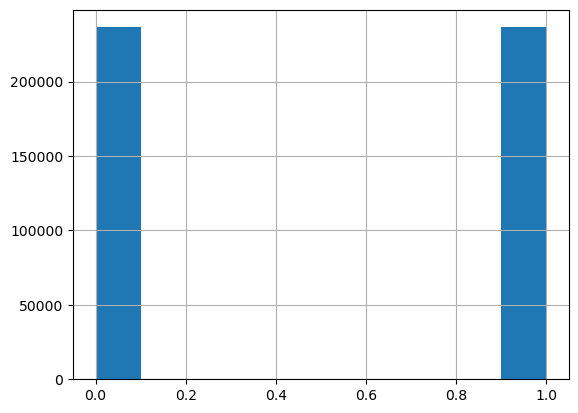

In [13]:
# turn gender into a binary variable
data["voice_gender_m"] = data["voice_gender"].apply(lambda x: 1 if x == "m" else 0)
data["voice_gender_f"] = data["voice_gender"].apply(lambda x: 1 if x == "f" else 0)
data.drop(columns="voice_gender", inplace=True)
data.voice_gender_m.hist()

# Understand data
Next we need to get an even better understanding of the data...

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 473078 entries, 3d060d83-adbd-44e0-afce-b826aa5381b1 to bb09b6f8-c3b5-47da-9505-51e8eadaadfe
Data columns (total 80 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   loudness_sma3_amean                    473078 non-null  float64
 1   loudness_sma3_stddevNorm               473078 non-null  float64
 2   loudness_sma3_percentile20.0           473078 non-null  float64
 3   loudness_sma3_percentile50.0           473078 non-null  float64
 4   loudness_sma3_percentile80.0           473078 non-null  float64
 5   loudness_sma3_pctlrange0-2             473078 non-null  float64
 6   loudness_sma3_meanRisingSlope          473078 non-null  float64
 7   loudness_sma3_stddevRisingSlope        473078 non-null  float64
 8   loudness_sma3_meanFallingSlope         473078 non-null  float64
 9   loudness_sma3_stddevFallingSlope       473078 non-null  float64
 

In [15]:
data.describe()

,loudness_sma3_amean,loudness_sma3_stddevNorm,loudness_sma3_percentile20.0,loudness_sma3_percentile50.0,loudness_sma3_percentile80.0,loudness_sma3_pctlrange0-2,loudness_sma3_meanRisingSlope,loudness_sma3_stddevRisingSlope,loudness_sma3_meanFallingSlope,loudness_sma3_stddevFallingSlope,...,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,voice_gender_m,voice_gender_f
count,473078.000000,473078.000000,473078.000000,473078.000000,473078.000000,473078.000000,473078.000000,473078.000000,473078.000000,473078.000000,...,473078.000000,473078.000000,473078.000000,473078.000000,473078.000000,473078.000000,473078.000000,473078.000000,473078.000000,473078.000000
mean,0.892217,0.968705,0.127121,0.650088,1.598294,1.471172,17.571638,10.454303,13.796541,7.936529,...,0.253431,3.224078,2.326454,0.270456,0.216097,0.207346,0.231744,-24.117084,0.500000,0.500000
std,0.442125,0.219222,0.147546,0.422911,0.803140,0.751935,8.746087,5.526138,6.947933,4.295753,...,0.296992,0.833036,0.816380,0.190132,0.139252,0.131144,0.138773,6.532007,0.500001,0.500001
min,0.005969,0.051130,0.001034,0.001034,0.001034,0.000000,-1.481236,0.000000,-17.031641,0.000000,...,0.000000,0.106741,0.000000,0.000000,0.000000,0.000000,0.000000,-81.795959,0.000000,0.000000
25%,0.572657,0.834155,0.037467,0.339346,1.014746,0.921121,11.224581,6.479595,8.789136,4.889129,...,0.086123,2.696629,1.769912,0.176000,0.133001,0.135500,0.144039,-27.235475,0.000000,0.000000
50%,0.846858,0.939730,0.082375,0.590103,1.514316,1.395894,16.712647,9.736423,13.001247,7.343142,...,0.170355,3.225806,2.291667,0.229286,0.183536,0.182000,0.217977,-22.522927,0.500000,0.500000
75%,1.154088,1.065279,0.162157,0.886762,2.076213,1.924612,22.801353,13.527158,17.801111,10.245518,...,0.317738,3.757829,2.838710,0.309000,0.258137,0.243750,0.297807,-19.627369,1.000000,1.000000
max,7.741005,5.407228,4.953964,8.381825,12.752979,11.084556,115.651161,79.575127,90.446686,72.247253,...,10.522104,9.584087,8.484849,9.740000,3.519545,10.190000,17.845364,-4.901050,1.000000,1.000000


#### Correlation
Lets correllate the features with the gender.
This gives us some basic informations which features could be relevant for gender detection.

In [16]:
"""
corr = data.corr()
target_cols = ["voice_gender_m", "voice_gender_f"]
corr_with_targets = corr[target_cols]
top_features = set()
for col in target_cols:
    abs_corr = corr_with_targets[col].abs().drop(target_cols, errors='ignore')
    abs_corr = abs_corr[abs_corr < 1.0]
    top_features.update(abs_corr.nlargest(10).index.tolist())
top_features.update(target_cols)
top_features_list = list(top_features)
subset_corr = corr.loc[top_features_list, top_features_list]
plt.figure(figsize=(12, 10))
sns.heatmap(subset_corr, annot=True, fmt=".2f", cmap="coolwarm", 
            vmin=-1, vmax=1, center=0)
plt.title("Top Correlations with Voice Gender Features")
plt.tight_layout()
plt.show()
"""

'\ncorr = data.corr()\ntarget_cols = ["voice_gender_m", "voice_gender_f"]\ncorr_with_targets = corr[target_cols]\ntop_features = set()\nfor col in target_cols:\n    abs_corr = corr_with_targets[col].abs().drop(target_cols, errors=\'ignore\')\n    abs_corr = abs_corr[abs_corr < 1.0]\n    top_features.update(abs_corr.nlargest(10).index.tolist())\ntop_features.update(target_cols)\ntop_features_list = list(top_features)\nsubset_corr = corr.loc[top_features_list, top_features_list]\nplt.figure(figsize=(12, 10))\nsns.heatmap(subset_corr, annot=True, fmt=".2f", cmap="coolwarm", \n            vmin=-1, vmax=1, center=0)\nplt.title("Top Correlations with Voice Gender Features")\nplt.tight_layout()\nplt.show()\n'

In [17]:
"""
corr_table = corr_with_targets.loc[top_features_list].stack().reset_index()
corr_table.columns = ['Feature', 'Gender', 'Correlation']
corr_table['Abs_Correlation'] = corr_table['Correlation'].abs()
corr_table = corr_table.sort_values('Abs_Correlation', ascending=False)
display(corr_table[['Feature', 'Gender', 'Correlation']].style
        .background_gradient(cmap='coolwarm', subset=['Correlation'])
        .format({'Correlation': '{:.2f}'})
        .set_caption('Top Correlations with Voice Gender Features'))
"""

"\ncorr_table = corr_with_targets.loc[top_features_list].stack().reset_index()\ncorr_table.columns = ['Feature', 'Gender', 'Correlation']\ncorr_table['Abs_Correlation'] = corr_table['Correlation'].abs()\ncorr_table = corr_table.sort_values('Abs_Correlation', ascending=False)\ndisplay(corr_table[['Feature', 'Gender', 'Correlation']].style\n        .background_gradient(cmap='coolwarm', subset=['Correlation'])\n        .format({'Correlation': '{:.2f}'})\n        .set_caption('Top Correlations with Voice Gender Features'))\n"

#### Random Forest Classifier
Lets create a random forest model to try classifing the gender by the audio features 

In [18]:
# create features and labels
target_cols = ["voice_gender_m", "voice_gender_f"]
X = data.drop(columns=target_cols)
y = data["voice_gender_m"]

In [19]:
# Select features for grid search
forest_feature_grid = {
    "n_estimators": [10, 100, 1000],
    "max_depth": [5, 10, 15],
}

In [20]:
"""
# grid search the best parameters
forest = RandomForestClassifier(random_state=rand_state)
forest_grid = GridSearchCV(forest, forest_feature_grid, verbose=2, cv=1)
forest_grid.fit(X, y)
"""

'\n# grid search the best parameters\nforest = RandomForestClassifier(random_state=rand_state)\nforest_grid = GridSearchCV(forest, forest_feature_grid, verbose=2, cv=1)\nforest_grid.fit(X, y)\n'

#### Train a Random Forest with fitting parameters
If I have time I'll promise to use GridSearch for this ^^"

In [21]:
target_cols = ["voice_gender_m", "voice_gender_f"]
X = data.drop(columns=target_cols)
y = data["voice_gender_m"]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

In [23]:
forest = RandomForestClassifier(
    n_estimators=500,
    max_depth=5,
    random_state=rand_state,
)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=500, random_state=10)

In [24]:
y_train_pred = forest.predict(X_train)
y_train_pred_proba = forest.predict_proba(X_train)[:, 1]
y_test_pred = forest.predict(X_test)
y_test_pred_proba = forest.predict_proba(X_test)[:, 1]

print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

Train Accuracy: 0.8776
Test Accuracy: 0.8750


In [25]:
(y_test - y_test_pred_proba).abs().describe()

count    94616.000000
mean         0.295999
std          0.160013
min          0.070293
25%          0.173619
50%          0.259584
75%          0.380264
max          0.920601
Name: voice_gender_m, dtype: float64

In [26]:
feature_importances = pd.DataFrame(forest.feature_importances_, columns=["feature_importance"], index=X_train.columns)
feature_importances.sort_values(by="feature_importance", ascending=False, inplace=True)
feature_importances

,feature_importance
HNRdBACF_sma3nz_amean,0.248368
slopeV0-500_sma3nz_amean,0.095318
shimmerLocaldB_sma3nz_amean,0.070289
F3frequency_sma3nz_amean,0.062055
F2frequency_sma3nz_amean,0.049093
...,...
loudness_sma3_percentile50.0,0.000034
F3amplitudeLogRelF0_sma3nz_amean,0.000032
loudnessPeaksPerSec,0.000007
StddevVoicedSegmentLengthSec,0.000006


In [ ]:
"""
# Save the model to a onnx file
onx = to_onnx(forest, X_train[:1].values.astype(np.float32), target_opset=12)

with open(os.path.join(model_path, "random_forest_model.onnx"), "wb") as f:
    f.write(onx.SerializeToString())
"""

In [27]:
# Save the model to a joblib file and load it again
dump(forest, os.path.join(model_path, "random_forest_model.joblib"))
forest = load(os.path.join(model_path, "random_forest_model.joblib"))

# Time for SHAP!
Lets see what the model thinks about features! 

In [28]:
i = 10
clip_id = X_test.index[i]
print(clip_id)
print(X_test.loc[clip_id,:], "\n")
print(f"Model prediction: {y_test_pred[i]}, probability: {y_test_pred_proba[i]:.4f}, true label: {y_test.iloc[i]}")

220fdb2f-c56c-4dbc-9c99-861369153af0
loudness_sma3_amean              0.545525
loudness_sma3_stddevNorm         0.940299
loudness_sma3_percentile20.0     0.032006
loudness_sma3_percentile50.0     0.426678
loudness_sma3_percentile80.0     0.973940
                                  ...    
MeanVoicedSegmentLengthSec       0.318000
StddevVoicedSegmentLengthSec     0.382199
MeanUnvoicedSegmentLength        0.237778
StddevUnvoicedSegmentLength      0.321689
equivalentSoundLevel_dBp       -26.097750
Name: 220fdb2f-c56c-4dbc-9c99-861369153af0, Length: 78, dtype: float64 

Model prediction: 1, probability: 0.7887, true label: 1


In [29]:
explainer = shap.TreeExplainer(forest)
shap_values = explainer.shap_values(X_test.iloc[i])

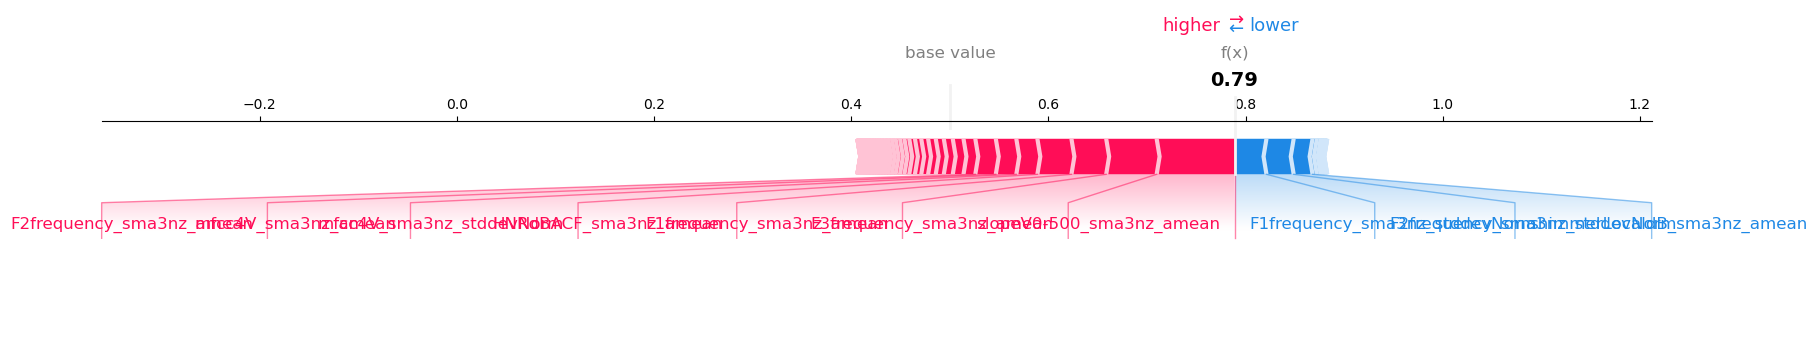

In [30]:
shap.force_plot(explainer.expected_value[1], shap_values[:, 1], feature_names=X_test.columns, matplotlib=True)

In [31]:
explainer = shap.Explainer(forest, X_train)
shap_values = explainer(X_test[:1000], check_additivity=False)

100%|===================| 1998/2000 [00:32<00:00]        

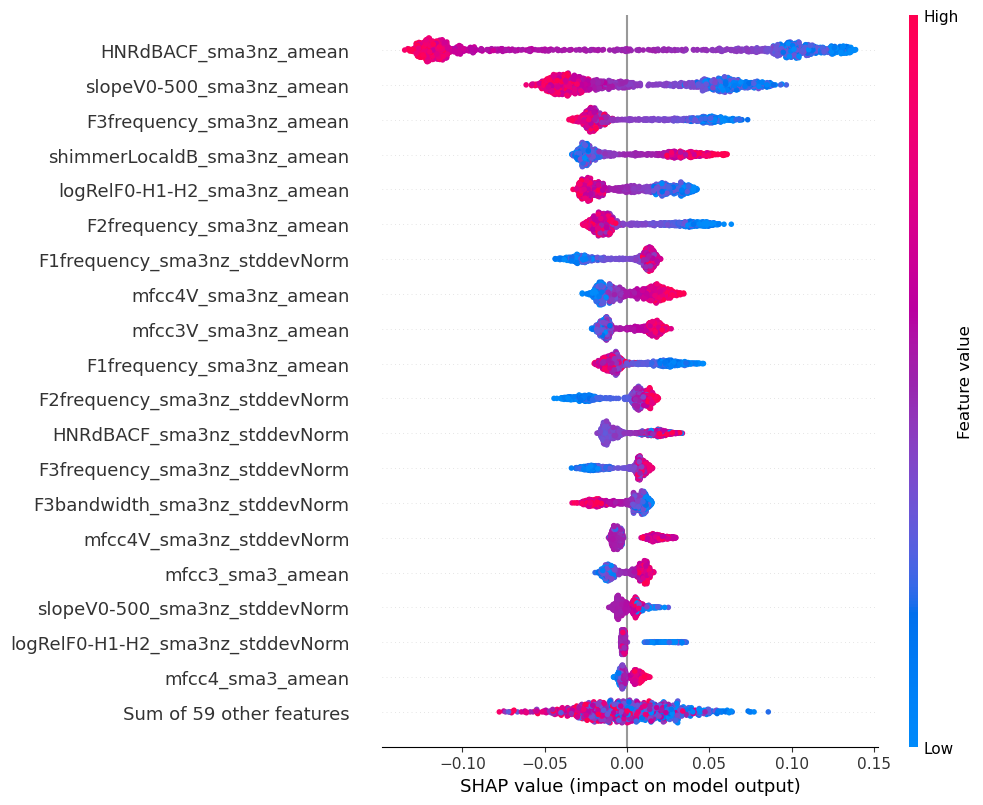

In [32]:
shap.plots.beeswarm(shap_values[:, :, 1], max_display=20)